In [1]:
from faster_rcnn_datamodule import DataModule
from BoxHead import BoxHead
from utils import non_max_suppression, output_decoding, average_precision
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.models.detection.image_list import ImageList

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def postprocess_bboxes(img_id, class_logits, box_preds):
    class_prob = F.softmax(class_logits[img_id], dim=1)
    max_probs, max_classes = torch.max(class_prob[:, 1:], dim=1)
    keep_indices = torch.where(max_probs > 0.5)
    
    start_indices = max_classes[keep_indices] * 4
    range_indices = torch.arange(4).to(start_indices.device)
    start_indices = start_indices.unsqueeze(1)
    indices = start_indices + range_indices
    
    regressed_boxes_t = torch.gather(box_preds[img_id][keep_indices], 1, indices)
    bboxes = output_decoding(regressed_boxes_t, proposals[img_id][keep_indices])

    bboxes = torch.column_stack([max_classes[keep_indices].unsqueeze(1), max_probs[keep_indices].unsqueeze(1), bboxes])
    
    sorted_indices = torch.argsort(bboxes[:, 1], descending=True)
    
    return bboxes[sorted_indices]

In [4]:
def postprocess_img(img_id, class_logits, box_preds):
    bboxes = postprocess_bboxes(img_id, class_logits, box_preds)
    pre_nms_bboxes = bboxes[:keep_num_preNMS]
    bboxes = non_max_suppression(pre_nms_bboxes)
    bboxes = bboxes.detach().cpu().numpy()
    return bboxes

In [21]:
imgs_path = '../partA/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '../partA/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '../partA/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '../partA/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
datamodule = DataModule(paths) 
     
box_head = BoxHead.load_from_checkpoint('/home/ny0221/cis680/hw4/partB/faster_rcnn/kzbxypv8/checkpoints/model_checkpoint.ckpt')

In [27]:
keep_topK = 200
keep_num_preNMS = 10

In [28]:
datamodule.setup("test")
test_loader = datamodule.test_dataloader()
test_iterator = iter(test_loader)
batch = next(test_iterator)
imgs, labels, bboxes, indices = batch
imgs = imgs.to(device)

In [29]:
all_preds = []
all_targets = []
img_idx = 0
for batch in test_loader:
    imgs, labels, bboxes, indices = batch
    imgs = imgs.to(device)
    
    batch_size = len(imgs)

    backout = box_head.backbone(imgs)

    im_lis = ImageList(imgs, [(800, 1088)]*imgs.shape[0])
    rpnout = box_head.rpn(im_lis, backout)

    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
           
    proposals = box_head.sort_proposals(proposals)
                
    feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list,proposals, P=7)
    class_logits, box_preds = box_head(feature_vectors)

    class_logits = torch.split(class_logits, keep_topK)
    box_preds = torch.split(box_preds, keep_topK)
    
    for i in range(batch_size): 
        preds = postprocess_img(i, class_logits, box_preds)
        if len(preds) > 0:
            preds = np.column_stack([np.full((len(preds), 1), img_idx), preds])
            all_preds.append(preds)
        if len(bboxes[i]) > 0:
            all_targets.append(np.column_stack([np.full((len(bboxes[i]), 1), img_idx), labels[i].numpy().reshape(-1,1), bboxes[i].numpy()]))
        img_idx += 1

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

ValueError: need at least one array to concatenate

In [20]:
average_precision(all_preds, all_targets, 0)

0.8574434980143798

In [78]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
imgs_for_viz = imgs.cpu().numpy()
imgs_for_viz = np.moveaxis(imgs_for_viz, 1, -1) 
# denormalize the image
imgs_for_viz = (imgs_for_viz * std) + mean
imgs_for_viz = np.clip(imgs_for_viz, 0, 1)

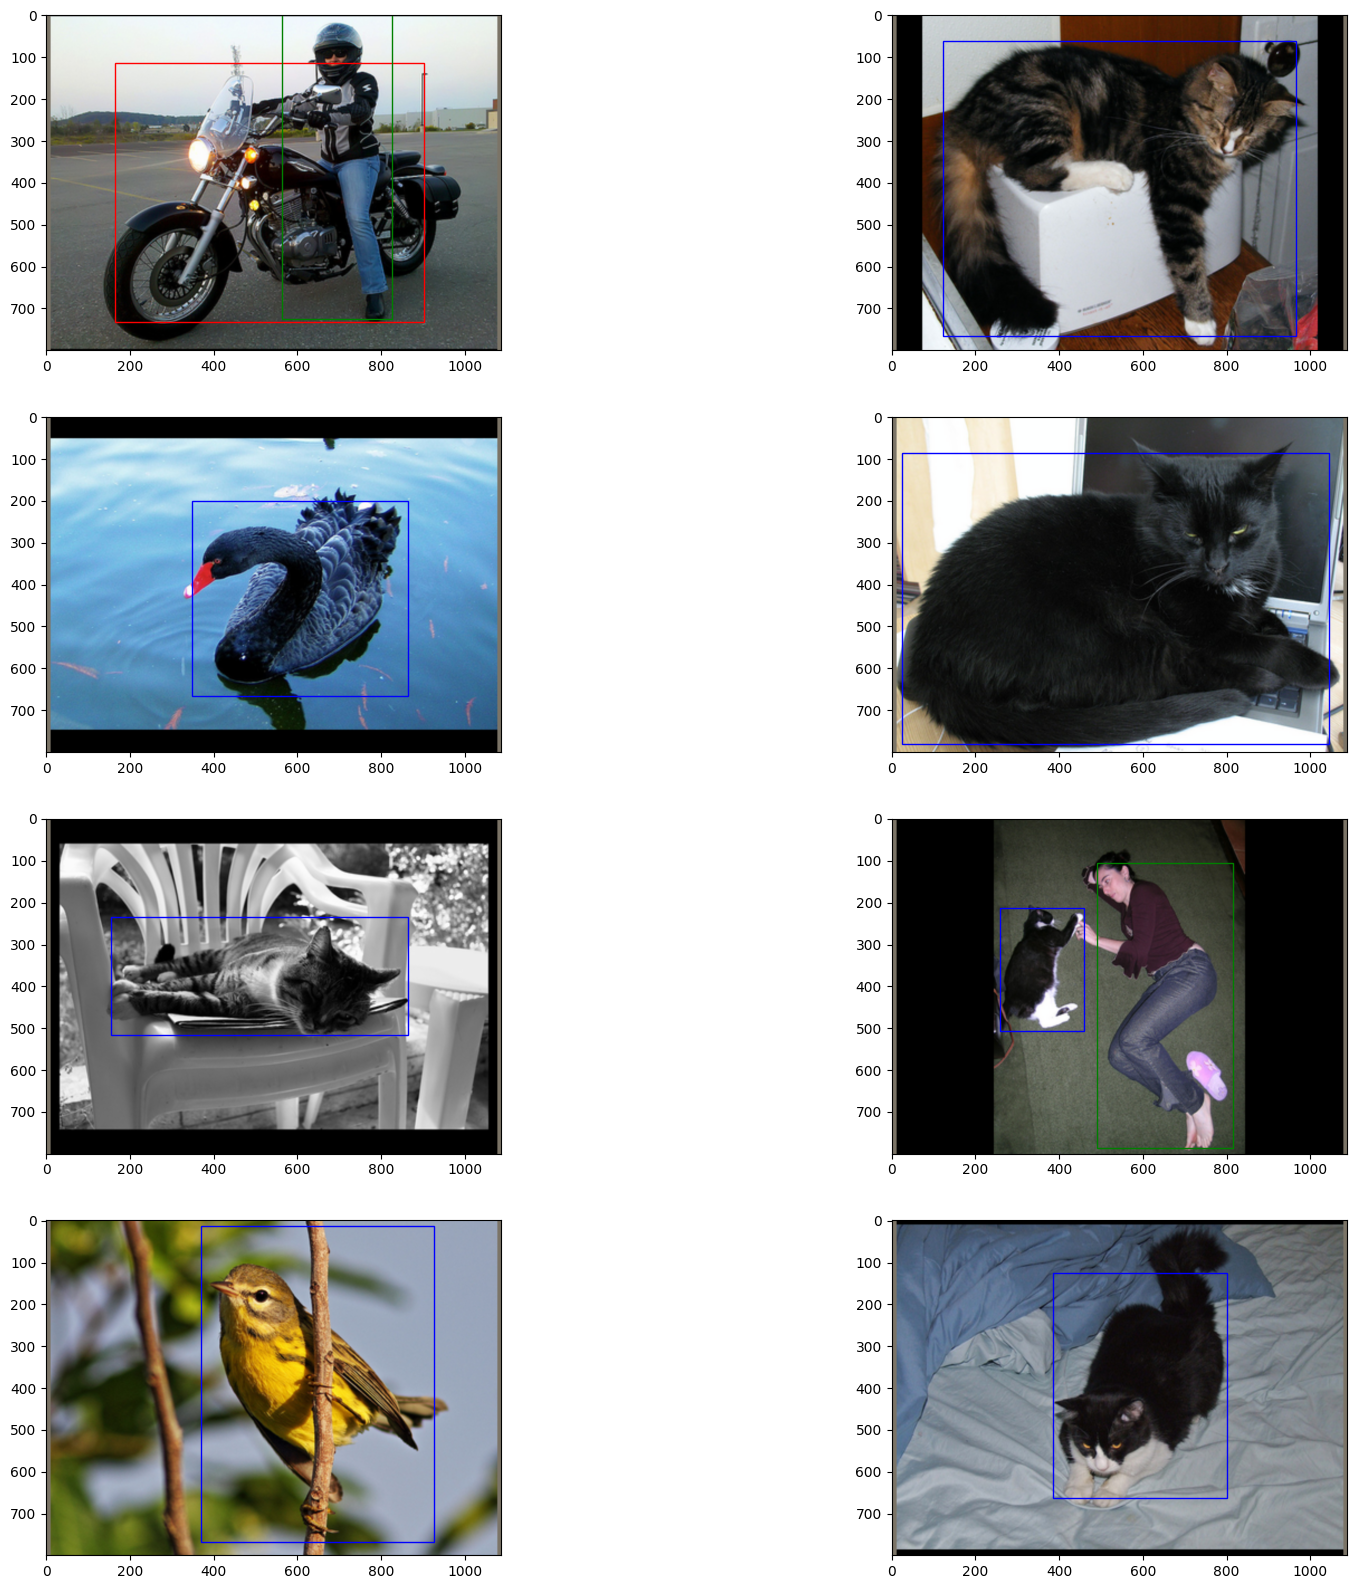

In [79]:
colors = ["red", "green", "blue"]
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

flat_axes = axes.ravel() 

for img_id, ax in enumerate(flat_axes):
    ax.imshow(imgs_for_viz[img_id])

    bboxes = postprocess_img(img_id, class_logits, box_preds)
    
    for bbox in bboxes:
        clas = int(bbox[0])
        x, y = bbox[2], bbox[3]
        width = bbox[4] - bbox[2]
        height = bbox[5] - bbox[3]
        rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=colors[clas], facecolor='none')
        ax.add_patch(rect)
